In [ ]:
!pip3 install --quiet ipywidgets ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
!mkdir utils_ex2
!wget -P utils_ex2/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/ex2/utils_ex2/utils.py

--2024-09-30 08:28:10--  https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/ex2/utils_ex2/utils.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/ex2/utils_ex2/utils.py [following]
--2024-09-30 08:28:10--  https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/ex2/utils_ex2/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14064 (14K) [text/plain]
Saving to: ‘utils_ex2/utils.py’

utils.py            100%[===================>]  13.73K  --.-KB/s    in 0.001s  

2024-09-30 08:28:11 (9.32 MB/s) - ‘utils_ex2/utils.

In [ ]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
platform = 'colab'

<font color='red'>**Instructions for navigating the notebook**: Please use the table of content provided by colab (top left).</font>

# 1. The parallel RC circuit

## 1.a: Charging the capacitor in the parallel RC circuit

In the last exercise, we took a closer look at the <ins>Nernst equation</ins> and the <ins>GHK equation</ins>. We also introduced the <ins>series RC circuit</ins> and the <ins>time constant</ins>.

These concepts help us to understand further how voltage gradients are established across cell membranes and how the temporal dynamics of these gradients charge and discharge a capacitor.

In fact, we can <ins>model the passive properties of real neuronal cell membranes</ins> using the **parallel RC circuit** (note that the last exercise did only intruduce the series RC circuit).
For this, we need an electrical circuit with a <ins>**capacitor** in parallel with a **resistor**</ins> that is <ins>in series with a **voltage source**</ins> (see figure below).
- The **capacitor** represents the **lipid bilayer** of the membrane.
- The **voltage source** represents the **Nernst potential** for a given ion.
- The **resistor** represent the **ion channels** (**conductances**) in the membrane for a given ion.


![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/ex2/utils_ex2/ex2_parallel.png?raw=true)

In section 2.a from the last exercise we used Euler's method to find the numerical solution for

$\begin{aligned}
    \frac{dV_C}{dt} = \frac{V - V_C}{R \cdot C} \\
    \end{aligned}$


The solution was



$V_C(t + \Delta t) = V_C(t) + \frac{V - V_C(t)}{R \cdot C} \cdot \Delta t$ = $(1 - \frac{\Delta t}{R \cdot C}) \cdot V_C(t) + \frac{\Delta t}{R \cdot C} \cdot V$

This equation nicely shows how the voltage accross a capacitor at time $t + \Delta t$ is a weighted sum of the current capacitor voltage $V_C(t)$ and the applied voltage $V$, with the weights depending on the time step $\Delta t$, the resistance $R$, and the capacitance $C$.

In this new circuit, the current $I_{in}$ splits at the node - the equations above no longer apply.

**Assignment**: Using KVL, KCL and Ohm's Law (see last exercise) mathematically describe how the voltage across the resistor changes over time when charing ($\frac{dV}{dt} = ...$). Note that the total input current divides between the capacitor and the resistor, based on the rate of voltage change across the capacitor and the resistive load.

---

If you found the correct euqation in the previous assignment, you can now use Euler's method to find the numercial solution.

**Assignment**: Using Euler's method find $V(t+\Delta t)$ = ...

---

In section 2.b from last exercise we had set some parameters and you completed the function <ins>rc_euler</ins> by adding the missing equation. Thus, you were able to plot the charging and discharging dynamics for a series RC circuit. Let's try this for the parallel RC circuit.

**Assignment**: Complete the code below and plot the charing curve in the parallel RC circuit.

In [ ]:
import numpy as np
def rc_parallel_circuit(V0, E_ion, R, C, I_in, t, dt):
    V_t = np.zeros(t.shape)
    V_t[0] = V0
    for i in range(1, len(t)):
        # Assignment: complete the equation below
        V_t[i] = ...
    return V_t

V0 = 0
E_ion = 0.3
R = 1e2
C = 1e-3
I_in = 1e-3
t = np.arange(0, 100, 0.1)
dt = 0.001

V_t = rc_parallel_circuit(V0, E_ion, R, C, I_in, t, dt)
V_t.shape


## 1.b: The neuronal membrane: Multiple conductances

We are now getting close to <ins>modelling the passive membrane properties</ins> of a real neuron. As you have seen, the Nernst potential calculates the reversal potential for each ion species seperately. To calculate the resting membrane potential, we need <ins>mainly three ion types</ins>: **sodium**, **potassium**, and **chloride**.

In biological neurons, the <ins>reversal potential</ins> for these ions is given by their different concentrations inside and outside the cell. That means, <ins>every ion species</ins> must have its "personal" driving force - a **voltage source**, if you will. Additionally, the membrane is selectively permeable for each ion species (different ion channels allow only crossing for specific ions) - thus also the **conductances** are specific for the ion type ($g_{ion}$).

We start with the following premises:
- Three ions are required to make up the resting membrane potential
- Each ion requires a voltage source and some conductance / resistance
- The cell membrane itself is modelled as a capacitor in parallel to the resistor(s)


Knowing how to model the **Nerst equation** (<ins>single ion</ins>) as an electrical circuit (**parallel RC**) and how the **GHK equation** is used to calculate the <ins>resting membrane potential including sodium, potassium and chloride ions</ins>, you can now get close to model the cell membrane of a neuron.

**Assignment**: Draw the equivalent electrical circuit modelling the cell membrane of a neuron with three conductances. Using this equivalent circuit, answer the following questions:
 - What is the relationship between the permeability of the membrane and the resistance for that ion?
 - How can you represent the electrical potential generated by an ion across the membrane?

**Assignment**: Using the equivalent circuit you just drew and Kirchhoff's laws, write the equation for the membrane potential of a neuron.

$V_m =...$

In [ ]:
# Question: Write a function to simulate the membrane potential using the 3-conductance model.
def membrane_potential(g_K, E_K, g_Na, E_Na, g_Cl, E_Cl):
    Vm = (g_K * E_K + g_Na * E_Na + g_Cl * E_Cl) / (g_K + g_Na + g_Cl)
    Vm = ...
    return Vm

# 2. Cable equation


So far, we have discussed membrane properties in steady-state conditions and over time. In neurons, <ins>changes in membrane potential</ins> often initially occur at the tip of long, thin cell membrane protrusions - called **dendrites** - and then <ins>passivly conduct</ins> along these dendrites towards the cell body (**soma**). Large changes in the membrane potential can trigger **action potentials** (**spikes**) at the soma which are propagated actively along the **axon**.

The conduction is most pronounced in long and narrow membrane compartments (dendrite and soma) which may be treated like a ‘cable’. If a cable (or an axon, for that matter), would receive a current input $I_0(t)$ at one end, the voltage change at location of input would depent on Ohms Law.

A typical problem in **cable theory** (Wilfrid Rall, 1977) is to determine the distribution of voltage $V (x, t)$ along the cable (ditance to the site of input $x$) and over time $t$.

![My Image](https://github.com/ManteLab/Iton_notebooks_public/blob/ex2/utils_ex2/ex2_cable.png?raw=true)


## 2.a: Cable resistance

Electrons when flowing through a cable (of copper for exemple) encounter a resistance due to the atoms in the cable. This is called the longitudinal resistance of the cable and is given by the formula:
$R_L = \frac{r_L \Delta x}{\pi a^2}$ where:
- $r_L$ is the specific longitudinal resistance of the cable [$\Omega \cdot mm$],
- $\Delta x$ is the length of the cable [$mm$].

**Assignment**: Given these information and the depiction in the figure above answer the following questions:
 - What is the unit of the longitudinal resistance $R_L$?
 - If you double the radius $a$ of the cable, what happens to the longitudinal resistance $R_L$?
 - If you double the length $\Delta x$ of the cable, what happens to the longitudinal resistance $R_L$?

Note, that we can relate the voltage drop along the cable to the current injected into the cable by using Ohm's law:

$\Delta V = - I_L \cdot R_L$ = $- I_L \cdot \frac{r_L \Delta x}{\pi a^2}$.

Applying cable theory to neurons, we established that ions flowing along the longitudinal axis of an axon experience a restistance $R_L$. However, ions do not only travel along the x-axis but also in radial direction. The resitance, ions encounter there is called the membrane resistance and is given by the formula:

$R_m = \frac{r_m}{2 \pi a \Delta_x}$ where:
- $r_m$ is the specific membrane resistance [$\Omega \cdot mm^2$],
- $\Delta x$ is the length of the cable [$mm$].
- $a$ is the radius of the cable [$mm$].

**Assignment**: Given these information and the depiction in the figure above answer the following questions:

- What is the unit of the membrane resistance $R_m$?
- If you double the radius $a$ of the cable, what happens to the specific membrane resistance $R_m$?
- If you double the length $\Delta x$ of the cable, what happens to the specific membrane resistance $R_m$?

## 2.b: The cable equation

For a passive membrane, the membrane potential $V(x,t)$ is determined by solving the following partial differential equation (linear cable equation):
$\tau_m \frac{\partial v}{\partial t} = \lambda^2 \frac{\partial^2 v}{\partial x^2} - v + r_m i_e$
where:
- The time-derivative term $\frac{\partial V}{\partial t}$ relates to chargin of the membrane capacitance.
- The second space-derivative term $\frac{\partial^2 V}{\partial x^2}$ relates to accumulation of longitudinal currents.
- $\tau_m = r_m c_m$ sets the scale for the **temporal** variation in the membrane potential. $\tau_m$ is called the membrane time constant.
- $\lambda = \sqrt{\frac{ar_m}{2r_l}}$ sets the scale for the **spatial** variation in the membrane potential. $\lambda$ is called the electrotonic length constant.
with:
- $c_m$ is the specific membrane capacitance,
- $a$ is the radius of the cable (axon in our case),
- $v = V - V_{rest}$ is the membrane potential relative to the resting potential,
- $r_m$ is the specific membrane resistance (= $1 M\Omega \cdot mm^2$),
- $r_L$ is the longitudinal resistance (= $1 k\Omega \cdot mm$),
- $i_e$ is the current injected into the cable.

**Assignment**: Given the information above answer the follwing questions:

- What is the  length constant $\lambda$?
- What is the membrane time constant $\tau_m$?

Assuming that:

$r_m = 1 M\Omega \cdot mm^2$

$r_L = 1 k\Omega \cdot mm$

$a = 2 \mu m$

- What is the unit of the  length constant $\lambda$?
- What is the unit of the membrane time constant $\tau_m$?


## 2.c: Steady-state solution (infinite cable)

We assume an infinite long **cable** and inject a constant current $i_e$ locally at $x = 0$.

The steady-state solution (so that $\frac{\partial v}{\partial t} = 0 $) of the cable equation then is:

$v(x) = \frac{i_e R_L}{2} e^{\frac{-|x|}{\lambda}}$ with $R_L = \frac{r_L \lambda}{\pi a^2}$.

Length constant: 1.00 mm


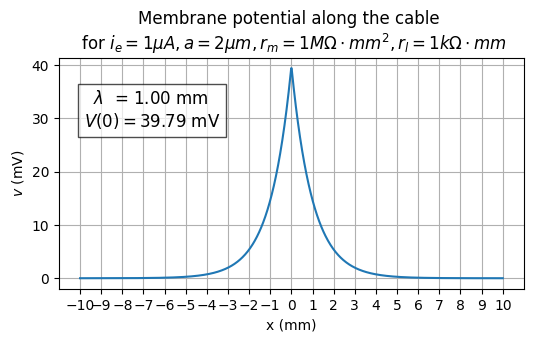

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
platform = 'notebook'
x = np.linspace(-10, 10, 1000)  # position along the cable in mm


i_e = 1e-6  # injected current in ampere
a = 2e-3  # radius of the cable in mm (2um)
r_m = 1e6  # specific membrane resistance in Ohm * mm^2
r_l = 1e3  # specific longitudinal resistance in Ohm * mm
lambda_elc = np.sqrt((a*r_m) / (2*r_l))  #  length constant in mm
print(f'Length constant: {lambda_elc:.2f} mm')
R_l = r_l * lambda_elc / (np.pi * a**2)  # longitudinal resistance in Ohm

v = (i_e * R_l / 2) * np.exp(-np.abs(x) / lambda_elc)  # membrane potential in mV
v0 = (i_e * R_l / 2)

# Plot the membrane potential along the cable
%matplotlib inline
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(600*px, 300*px))
ax.plot(x, v)  # plot in mV
ax.set_xlabel('x (mm)')
ax.set_ylabel(r'$v$ (mV)')
ax.set_title('Membrane potential along the cable \n for ' + r'$i_e = 1 \mu A, a = 2 \mu m, r_m = 1 M\Omega \cdot mm^2, r_l = 1 k\Omega \cdot mm$')
text_display = ax.text(0.2, 0.7, r'$\lambda$ ' + f' = {lambda_elc:.2f} mm \n' + r'$V(0) =$' +  f'{v0:.2f} mV', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))
ax.set_xticks(np.arange(-10, 11, 1))
plt.grid()
plt.show()

To get a better understanding for the parameters in the passive cable equation, you can use an interactive plot below to modify the specific resistances $r_L$ and $r_m$ as well as the amount of current injected $i_e$ (at $x=0$) and the radius of the denrite $a$.

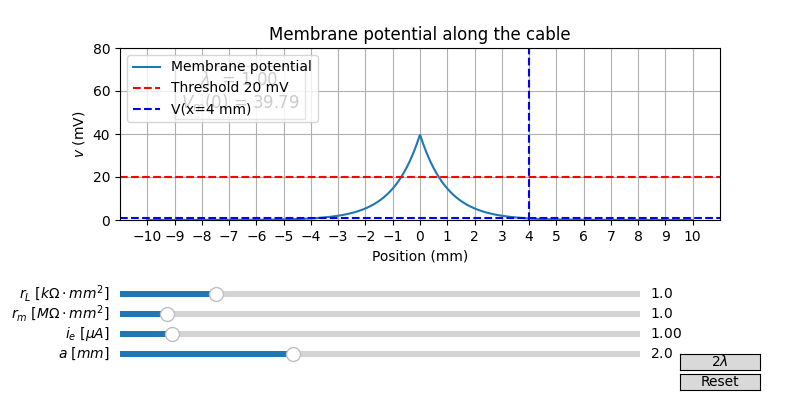

In [ ]:
from utils_ex2.utils import plot_cable_v
if platform == 'notebook':
    %matplotlib notebook
plt.close()
plot_cable_v(y_axis_lim=80, plot_lambda=True) # y_axis_lim is the limit of the y-axis (in mV), default is 80

**Assignment**: Using the provided information (cable equation and interactive plot), answer the following questions:

- What happens if you increase the radius $a$? (Hint: there is a second, not obvious effect which you can visualize in the interactive plot above by changing the `y_axis_lim` parameter in the function `plot_cable_v` to a lower value (e.g., 20 mV).
- What happens if you increase the injected current $i_e$?
- What happens if you increase the longitudinal resistance $R_l$? Why?
- What happens if you increase the membrane resistance $R_m$? Why?



Did you wonder, where the <ins>current that changes our membrane potential</ins> comes from in the first place? In neurons, these inputs are usually caused by ions crossing the membrane via **open ion channels**. Why do they open? That depends on the ion channel and you will hear a lot more about this during the rest of the course. For now, we assume that the <ins>initial current input</ins> at $x=0$ <ins>is just a given</ins>.

However, along the axon we find more ion channels (let's assume that they allow sodium ions to enter the axon, when open). These channels are likely closed but <ins>change their probability to open</ins> if the <ins>membrane potential at their location crosses a certain **threshold**</ins>. We call them **voltage-gates ion channels**.


**Assignment**: In the code for the interactive plot above, find the function `plot_cable_v` and change the value of the parameter `plot_lambda` to `True`, then rerun the cell. This will plot the vertical line at x=4mm, which represents twice the length constant $\lambda$. It will also plot a horizontal line showing the membrane potential at x=4mm.

Press the button $2\lambda$ (above the ` Reset ` button). This will set $r_m = 6.4 MΩ·mm^2$, $r_l = 0.8 kΩ·mm$ and $a = 1 μm$. It also sets the injected current $i_e = 0.39 μA$, resulting in a membrane potential of 100 mV at $x = 0$.

---

In the plot above, we generate a <ins>prolonged atrificial "spike"</ins> (assume constant current injection) at $x = 0$ to generate a peak voltage of 100mV.

The voltage-gated sodium channels at $x = 2\lambda = 4 mm$ could allow the artificial spike to actively propergate further if the membrane potential at location exceeded their opening-**theshold** voltage of 20mV (let the resting potential be 0V).

---

**Assignment**:
- Looking at the interactive plot above, will these settings allow the spike to be actively propagated beyond $x = 2\lambda = 4 mm$?
- Double the radius of the axon. This will change $\lambda$ but we keep the absolute position of the two nodes fixed i.e $x_0 = 0$ and $x_1 = 4 mm$. What happems to the membrane potential at $x=0$? How much current do we need to inject into the axon to again reach a membrane potential of 100mV at $x = 0$?
- After adjusting the injected current, do the new parameters allow the spike to be actively propagated beyond $x = 2\lambda = 4 mm$?



<font color='red'>** Potential additional question: In a second axon extra membrane tightly surrounds the axon between the nodes. As a consequence the membrane resistance increases by a factor of 4, while the capacitance decreases by a factor of 4. In all other respects the axon is similar to the first one, with the same absolute position of the two nodes and the radius of a = 2 μm. Again, does this change the answer to question 2?**</font>


## 2.d: An axon with three injection sites

Next, we assume again an infinite cable but this time we inject constant currents $i_{1}$, $i_{2}$ and $i_{3}$ simultaneously at three locations: $x = 0$, $x = x_1$ and $x = x_2$.

Here the linear cable equation that we have already introduced for all three injection sites:

$\tau_m \frac{\partial v_1}{\partial t} = \lambda^2 \frac{\partial^2 v_1}{\partial x^2} - v + r_m i_{e_1}$ for $x = 0$

$\tau_m \frac{\partial v_2}{\partial t} = \lambda^2 \frac{\partial^2 v_2}{\partial x^2} - v + r_m i_{e_2}$ for $x = x_1$

$\tau_m \frac{\partial v_3}{\partial t} = \lambda^2 \frac{\partial^2 v_3}{\partial x^2} - v + r_m i_{e_3}$ for $x = x_2$

Then the steady-state membrane potential at location $V(x)$ is given by :

$V(x) = \frac{R_L}{2} (i_{0} e^{\frac{-|x - x_0|}{\lambda}} + i_{1} e^{\frac{-|x_1|}{\lambda}} + i_{2} e^{\frac{-|x - x_2|}{\lambda}})$.


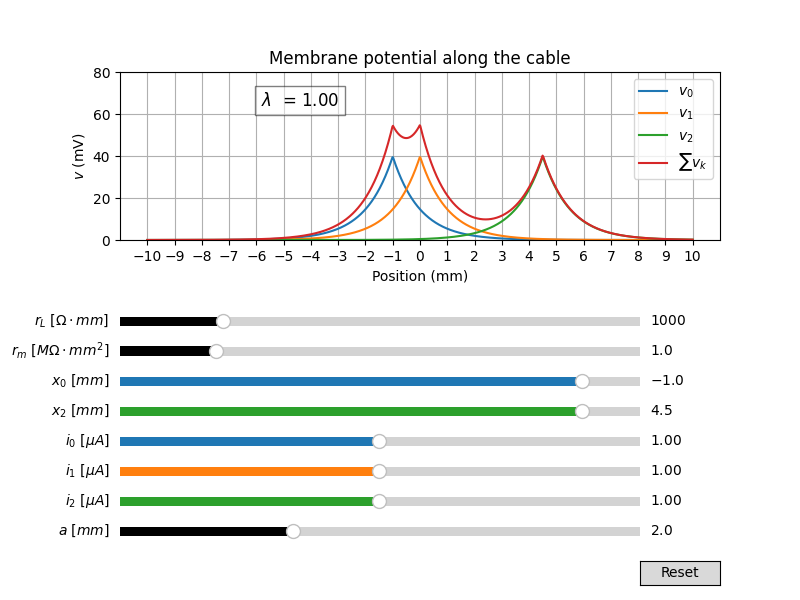

In [ ]:
from utils_ex2.utils import plot_multi_injection
plot_multi_injection(y_axis_lim=80)

In the last assignment we saw that input (current injection) at $x=0$ propagates along an axon where it may or may not trigger a spike at $x=4mm$. Although the mechanism of **action potential propagation** in biological axons is more complicated (we will hear about this later during the course), the general idea of what we saw, holds true.

**Assignment**: In the **interactive plot** above you can change individual parameters of three current injections. Adjust the settings and observe, what changes. Note that $x_0$ can only occure to the left of $x_1$ and $x_2$ will only occure to the right of $x_1$.

---

We use this example to showcase an interesting mechanism found in neurons: summation of inputs.

**Assignment**: Compare the single-input case with the three-inputs case and try to answer the following questions:

- Which of the two cases is more relevant for action potential propagation in axons and why?
- What exactly does the red line in the interactive plot above show and how relevant is this line for biological axons?
-  Try to identify three details in the cable equation models above that incorrecly, inadequately, incompletely or poorly represent the mechanisms in biological neurons.

# 3. Integrate-and-Fire neuron and delayed synaptic inputs

You now have a good understanding of **cable theory** and how passive conduction affects voltage distribution along a neuron’s axon or dendrite. As mentioned already, inputs arriving somewhere along dendrites passivly travel to the soma where they are **integrated**.

The **cable equation** has provided us with the tools to calculate how signals <ins>attenuate and decay</ins> as they conduct along a dendrite. Building on this foundation, we introduce the **Integrate-and-No-Fire neuron model** — a simplified representation of **neuronal input integration**.

The following properties of a neuron can be studied using the the Integrate-and-No-Fire model:

  1.	**Input integration**: How a neuron accumulates inputs from multiple synapses over time.
  2.	**Synaptic weights**: How varying synaptic strengths impact membrane potential changes.
  3.	**Delays**: How the physical properties of dendrites introduce delays in signal propagation.
  4.	**Summation**: How inputs arriving at different times and different locations along the dendrites are summed.



## 3.a: Delays: How cable theory affects synaptic inputs

In the previous section, we have learned that the **passive properties** of **dendrites** cause the membrane potential to attenuate and decay as they travel towards the soma. Note, that passive propagation doesn't happen instantaneously. Aided by insights of **cable theory**, the delay  $d_i$ for a synaptic input located at a distance  $x_i$  is given by:


$d_i = \frac{x_i}{v}$

where  $v$  is the propagation velocity along the dendrite, calculated using physical properties such as the length constant ${\lambda}$ and the membrane time constant ${\tau_m}$. $v$ is given by:

$v = \frac{2\lambda}{\tau_m}$

These equations highlight how dendritic properties like resistance, capacitance, and geometry influence the time it takes for a synaptic input to arrive at the soma.



## 3.b: The Integrate-and-No-Fire Model

In the Integrate-and-No-Fire model, we model the neuron’s membrane potential  V(t) at the soma as the cumulative sum of all synaptic inputs that have arrived up to time $t$. Each synaptic input contributes to the membrane potential based on its:

-	Synaptic weight ( $w_i$ ): The strength of the synaptic input.
-	Delay ( $d_i$ ): The time it takes for the input to reach the soma.



Mathematically, the membrane potential can be expressed as:


$V(t) = V_{\text{rest}} + \sum_{i=1}^{N} \sum_{j} w_i \cdot \delta(t - (s_{ij} + d_i))$

-	 $V_{\text{rest}}$ : Resting membrane potential (set to 0 for simplicity).
-	 $N$ : Number of synapses.
-	 $s_{ij}$ : Input times $j$ at synapse $i$ (note that multiple inputs could arrive at a single synapse).
-	 $\delta$ : Kronecker delta function, ensuring the input is considered only if $t = s_{ij} + d_i$ .

In [ ]:
from utils_ex2.utils import iplot_InoF_model
iplot_InoF_model()

interactive(children=(FloatSlider(value=5.0, description='Synaptic  Weight 1:', step=5.0, style=SliderStyle(de…

**Assignment**: Without changing parameters in the interactive plot obove, look at the input times in all three synapses. How long do the delays $d_1$, $d_2$, and $d_3$ have to be, so that all three inputs arriveat the soma simultaneously at  t=50ms? Adjust the synaptic delays $d_i$ using the sliders and explain how this synchronization will affect the membrane potential at  t=50ms.

---

Using the provided “Integrate-and-No-Fire” model, consider three synapses located along a dendrite at different distances from the soma:

-	Synapse 1 is located at a distance  $x_1$ = 1  mm from the soma.
-	Synapse 2 is located at  $x_2$ = 2  mm.
-	Synapse 3 is located at  $x_3$ = 3  mm.

All synapses receive inputs at t=10ms and t=40ms and each input changes the membrane potential locally to +1mV.

Assume the following parameters for the dendrite:

-	Membrane resistance per unit length:  $r_m$ = 1  MΩ·mm
-	Axial (internal) resistance per unit length:  $r_i$ = 100  Ω·mm
-	Membrane capacitance per unit length:  $c_m$ = 1  μF/mm
- Uniform radius of $a$ = 1 mm
- Membrane time constant $\tau_m$ = 1 s
-	The dendrite is modeled as a passive cable with uniform properties, assuming that only delay but not voltage is affected by the resistance.

**Assignment**:

- Calculate the delays  $d_i$  for each synaptic input.
- Compute the somatic membrane potential  $V(t)$  at  t=50ms using the calculated delays (synaptic weights $w_1$ = 5, $w_2$ = 10, and $w_3$ = 15).

---

Remember when we talked about action potential propagation along the axon (2.c) and wondered where the original input comes from? At the **axon hillock**, the area at the soma where the axon starts, synaptic inputs are integrated - if the membrane potential there crosses a certain theshold, the neuron will fire an action potential.

Our "Integrate-and-No-Fire” model does not implement this functionality by definition (that's why we call it "no-fire"). In the next exercise we will implement finally upgrade and work with an "Integrate-and-Fire” model.

Until then, consider a neuron that does have a threshold to trigger action potentials at $V_{th} = 15 mV$. It receives two synaptic inputs of $1mV$ that individually are not sufficient to cross the firing threshold. However, both inputs combined can cause the neuron to fire. The synaptic weights are  $w_1 = w_2 = 10$, and the delays are $d_1 = d_2 = 5 ms$.

**Assignment**: Determine at what time (if at all) the neuron fires given that:

- Inputs to synapse 1 arrive at  $t_1 = 10 \text{ms}$  and  $t_2 = 30 \text{ms}$.
- Inputs to synapse 2 arrive at  $t_1 = 10 \text{ms}$  and  $t_2 = 12 \text{ms}$.


**Assignment**: Modify the mathematical model to include membrane potential attenuation with a time constant  $\tau_m$. Write the updated equation for $V(t)$ and explain how this changes the neuron’s response to synaptic inputs.